This notebook has data cleaning and some feature engineering.

## Data Overview

In [358]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [359]:
df = pd.read_csv('datasets/train.csv')
df_test = pd.read_csv('datasets/test.csv')
base_residuals = pd.read_csv('datasets/base_residuals.csv', index_col=0)

In [360]:
df.shape

(2051, 81)

We'll examine different features relationship to home price as well as the residuals from our base model.
The base model is a linear regression trained on
* Neighborhood
* Overall Quality
* Year Built
* Gr Liv Area (above surface square footage)
* Year sold

In [361]:
base_residuals.columns = ['base_residual']

In [362]:
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [363]:
df = df.join(base_residuals)

In [364]:
df.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [365]:
df.dtypes

Id                 int64
PID                int64
MS SubClass        int64
MS Zoning         object
Lot Frontage     float64
                  ...   
Mo Sold            int64
Yr Sold            int64
Sale Type         object
SalePrice          int64
base_residual    float64
Length: 82, dtype: object

In [366]:
pd.DataFrame(df.isna().sum(), columns = ['na_count']).query('na_count > 0')

,na_count
Lot Frontage,330
Alley,1911
Mas Vnr Type,22
Mas Vnr Area,22
Bsmt Qual,55
Bsmt Cond,55
Bsmt Exposure,58
BsmtFin Type 1,55
BsmtFin SF 1,1
BsmtFin Type 2,56


## Helper Functions

### Read Ordinal Scale

In [367]:
def read_map(map_):
    """map_ should be keyword 'qual' or "qual_na" or a dict. """

    # print(map_, type(map_))
    if type(map_) == dict:
        return map_

    elif type(map_) == list:
        return {val: i for i, val in enumerate(map_)}

    elif map_ == 'qual':
        return {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}

    elif map_ == 'qual_na':
        return {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

    else:
        return map_

In [368]:
def ord_read(col_name, map_ = 'qual', df = df):
    map_ = read_map(map_)

    return df[col_name].map(map_)
        

In [369]:
def ord_gb_price(col_name, map_ = 'qual', col = 'LogPrice_clipped', df = df):
    map_ = read_map(map_)
    r_map = {val: key for key, val in map_.items()}
    idx_order = [r_map[i] for i in sorted(r_map.keys())]
    return df.groupby(col_name).agg([np.mean, len])[[col]]\
        .reindex(idx_order)

In [370]:
def ord_plot(col_name, map_ = 'qual', col = 'LogPrice_clipped', df = df):
    map_ = read_map(map_)
    gb = ord_gb_price(col_name, map_, col, df)
    gb.index = pd.RangeIndex(len(gb.index))
    # print(gb)
    sns.scatterplot(
        x = gb.index, 
        y = gb[(col, 'mean')],
        s = 1 + 4*np.sqrt(gb[(col, 'len')]))
    # return gb

    idx = ord_read(col_name, map_, df)
    sns.regplot(x = idx, y = df[col], scatter = False, color = 'orange')
    plt.show()

## Feature exploration

#### Normalize price

In [371]:
df['LogPrice_clipped'] = df['SalePrice'].transform(np.log).clip(lower = 10.5)

Log sale price is more normal (less skew and kurtosis) than untransformed version.

In [372]:
df[['SalePrice', 'LogPrice_clipped']].skew()

SalePrice           1.557551
LogPrice_clipped    0.036952
dtype: float64

In [373]:
df[['SalePrice', 'LogPrice_clipped']].kurtosis()

SalePrice           3.579003
LogPrice_clipped    0.771849
dtype: float64

1 standard deviation in price is close to 0.4 on the log scale.

In [487]:
df[['LogPrice_clipped', 'base_residual']].agg(['mean', 'std'])

,LogPrice_clipped,base_residual
mean,12.025454,0.001632
std,0.406098,0.165220


#### Replace small neighborhoods

In [375]:
df.groupby('Neighborhood').agg([np.mean, len])[['SalePrice']].sort_values(by = ('SalePrice', 'len')).head()

SalePrice    
                       mean len
Neighborhood                   
Landmrk       137000.000000   1
GrnHill       280000.000000   2
Greens        188666.666667   3
Blueste       144566.666667   6
Veenker       253570.588235  17

In [376]:
small_neighborhoods = df.groupby('Neighborhood').agg([np.mean, len])[['SalePrice']].sort_values(by = ('SalePrice', 'len')).index[:4]
small_neighborhoods


Index(['Landmrk', 'GrnHill', 'Greens', 'Blueste'], dtype='object', name='Neighborhood')

In [377]:
def neighborhood_clean(df):
    df['Neighborhood'] = df['Neighborhood'].transform(\
        lambda x: 'other' if x in small_neighborhoods else x)

#### Pool - Since very few houses have pools we can just binarize presence of a pool.

In [378]:
df['Pool Area'].value_counts()

0      2042
519       1
576       1
800       1
228       1
480       1
648       1
738       1
368       1
561       1
Name: Pool Area, dtype: int64

In [379]:
df['Pool QC'].value_counts()

Gd    4
Fa    2
TA    2
Ex    1
Name: Pool QC, dtype: int64

In [380]:
def pool_clean(df):
    df['isPool'] = df['Pool Area'] > 0
    df.drop(columns = ['Pool Area', 'Pool QC'], inplace=True)

#### Alleys

In [381]:
df['Alley'].value_counts()

Grvl    85
Pave    55
Name: Alley, dtype: int64

In [382]:
def alley_clean(df):
    df['Alley'].fillna('None', inplace = True)

#### Lot size

In [467]:
df['Lot Frontage'].min()

21.0

<AxesSubplot:xlabel='Lot Frontage', ylabel='Count'>

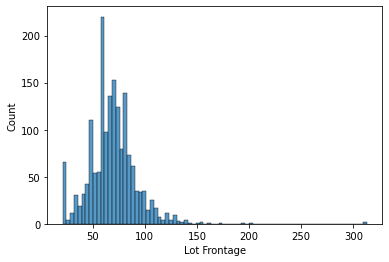

In [466]:
sns.histplot(df['Lot Frontage'])

<AxesSubplot:>

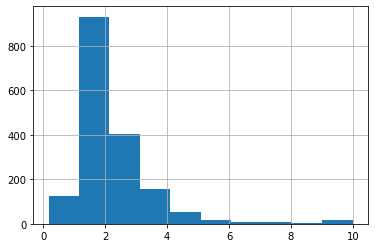

In [383]:
(df['Lot Area']/df['Lot Frontage']**2).clip(upper = 10).hist()

In [384]:
lot = (df['Lot Area']/df['Lot Frontage']**2) 

In [385]:
lot[lot < 1]

5       0.878683
20      0.734282
45      0.967000
95      0.550469
116     0.988806
          ...   
1920    0.625000
1932    0.628311
1952    0.175915
1994    0.953333
2023    0.675117
Length: 67, dtype: float64

In [386]:
df['Lot Area'].min()

1300

In [387]:
df[df['Lot Frontage'].isna()].head(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,base_residual,LogPrice_clipped
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,3,2010,WD,130500,0.280580,11.779129
7,145,535154050,20,RL,NaN,12160,Pave,NaN,IR1,Lvl,...,NaN,MnPrv,NaN,0,5,2010,COD,142000,-0.065844,11.863582


In [474]:
def lot_features(df):
    df['Lot Ratio'] = df['Lot Area']/df['Lot Frontage']**2
    

#### Masonry

In [389]:
df['Mas Vnr Type'].value_counts(dropna=False)

None       1218
BrkFace     630
Stone       168
NaN          22
BrkCmn       13
Name: Mas Vnr Type, dtype: int64

In [390]:
df_test['Mas Vnr Type'].value_counts(dropna = False)

None       534
BrkFace    250
Stone       80
BrkCmn      12
CBlock       1
NaN          1
Name: Mas Vnr Type, dtype: int64

In [391]:
df['Mas Vnr Area'].value_counts(dropna = False)

0.0      1216
NaN        22
120.0      11
176.0      10
200.0      10
         ... 
142.0       1
215.0       1
235.0       1
233.0       1
426.0       1
Name: Mas Vnr Area, Length: 374, dtype: int64

In [392]:
def masonry_clean(df):
    df['Mas Vnr Type'].fillna('None', inplace = True)
    df['Mas Vnr Area'].fillna(0.0, inplace = True)

#### Basement

Note that the basement bathrooms are handled later.

In [393]:
basement = df.loc[:, "Bsmt Qual":"Total Bsmt SF"].copy()
basement['LogPrice_clipped'] = df['LogPrice_clipped']
basement['base_residual'] = df['base_residual']

In [394]:
basement.head()

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,LogPrice_clipped,base_residual
0,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,11.779129,0.280580
1,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,12.301383,0.044222
2,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,11.599103,0.139583
3,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,12.066811,-0.007865
4,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,11.838626,-0.115473


##### NA checks

3 unfinished basements are marked as good quality.

In [395]:
basement[basement['Bsmt Exposure'].isna() & ~basement['Bsmt Qual'].isna()]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,LogPrice_clipped,base_residual
1456,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,12.264856,-0.236199
1547,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,12.308178,0.068318
1997,Gd,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0,12.167851,0.152073


In [396]:
basement[basement['BsmtFin SF 1'].isna()]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,LogPrice_clipped,base_residual
1327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.277203,0.223866


In [397]:
df.iloc[1327].isna().sum()

15

##### Basement Quality and condition

In [398]:
basement.fillna({'Bsmt Qual': 'NA', 'Bsmt Cond': 'NA'}, inplace = True)

Looks like relationship of basement qual to log price is increasing and likely either linear or quadratic.

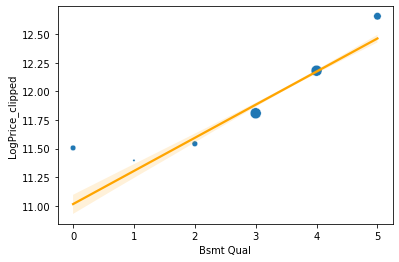

In [399]:
ord_plot('Bsmt Qual', 'qual_na', df = basement)

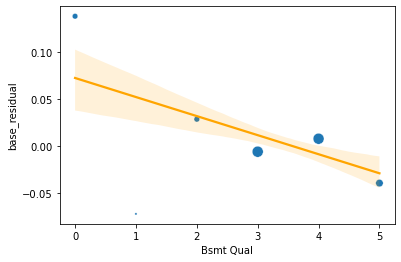

In [400]:
ord_plot('Bsmt Qual', 'qual_na', col = 'base_residual', df = basement)

In [401]:
basement['Bsmt Qual'].value_counts()

TA    887
Gd    864
Ex    184
Fa     60
NA     55
Po      1
Name: Bsmt Qual, dtype: int64

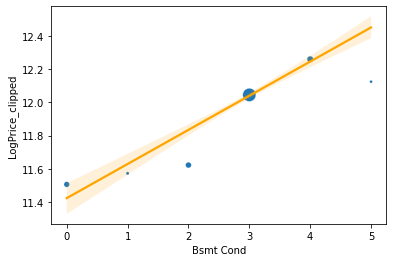

In [403]:
ord_plot('Bsmt Cond', 'qual_na', df = basement)

Interestingly, the relationship of basement condition to price is a bit unclear, however, it does have a clear linear relationship with our base residuals.

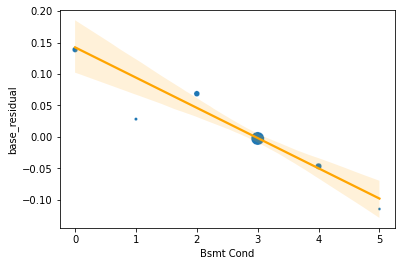

In [404]:
ord_plot('Bsmt Cond', 'qual_na', 'base_residual', basement)

Basement condition has almost all values typical so it has low coverage but, it is useful information to the model where it deviates from the mode.

In [405]:
basement['Bsmt Cond'].value_counts()

TA    1834
Gd      89
Fa      65
NA      55
Po       5
Ex       3
Name: Bsmt Cond, dtype: int64

In [406]:
basement.groupby(['Bsmt Cond', 'Bsmt Qual']).count()[['LogPrice_clipped']]

LogPrice_clipped
Bsmt Cond Bsmt Qual                  
Ex        Gd                        1
          TA                        2
Fa        Fa                       14
          Gd                        3
          Po                        1
          TA                       47
Gd        Ex                       20
          Fa                        2
          Gd                       47
          TA                       20
NA        NA                       55
Po        Ex                        1
          Fa                        3
          TA                        1
TA        Ex                      163
          Fa                       41
          Gd                      813
          TA                      817

##### Exposure

In [407]:
basement.fillna({'Bsmt Exposure': 'NA'}, inplace = True)

In [408]:
basement['Bsmt Exposure'].value_counts()

No    1339
Av     288
Gd     203
Mn     163
NA      58
Name: Bsmt Exposure, dtype: int64

In [409]:
basement.groupby('Bsmt Exposure').mean()[['LogPrice_clipped', 'base_residual']]

,LogPrice_clipped,base_residual
Bsmt Exposure,,
Av,12.165019,-0.021823
Gd,12.431982,-0.075246
Mn,12.082472,-0.001606
NA,11.543848,0.131226
No,11.947724,0.013112


Linear fit between exposure and log price

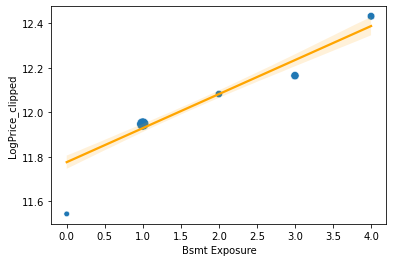

In [410]:
ord_plot('Bsmt Exposure', ['NA', 'No', 'Mn', 'Av', 'Gd'], df = basement)

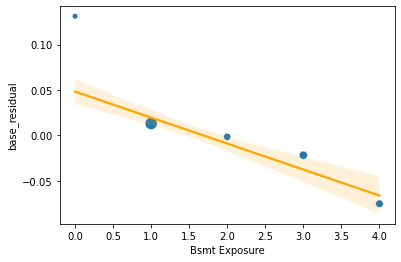

In [411]:
ord_plot('Bsmt Exposure', ['NA', 'No', 'Mn', 'Av', 'Gd'], col = 'base_residual',df = basement)

##### Finish type

For the first type, "GLQ" (Good Living Quarters) has significantly more value (~ 1 sd) than the others, the rest are approximately equal.

In [412]:
basement['BsmtFin Type 1'].value_counts()

GLQ    615
Unf    603
ALQ    293
BLQ    200
Rec    183
LwQ    102
Name: BsmtFin Type 1, dtype: int64

In [413]:
basement.groupby('BsmtFin Type 1')['LogPrice_clipped'].mean().sort_values()

BsmtFin Type 1
Rec    11.829262
BLQ    11.879686
LwQ    11.889080
Unf    11.933978
ALQ    11.970576
GLQ    12.316192
Name: LogPrice_clipped, dtype: float64

For the second type, good quality basements are also worth a bit more than average so I'll count this in the good quality basement feature.

In [414]:
basement['BsmtFin Type 2'].value_counts()

Unf    1749
Rec      80
LwQ      60
BLQ      48
ALQ      35
GLQ      23
Name: BsmtFin Type 2, dtype: int64

In [415]:
basement.groupby('BsmtFin Type 2')['LogPrice_clipped'].mean().sort_values()

BsmtFin Type 2
BLQ    11.913247
LwQ    11.965819
Rec    11.969344
Unf    12.045873
ALQ    12.062562
GLQ    12.221455
Name: LogPrice_clipped, dtype: float64

In [416]:
basement.query('`BsmtFin Type 2` == "GLQ"')

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,LogPrice_clipped,base_residual
32,Gd,Gd,Av,LwQ,437.0,GLQ,1057.0,0.0,1494.0,12.506177,-0.081089
92,Gd,TA,No,LwQ,36.0,GLQ,596.0,122.0,754.0,12.122691,0.036467
191,Gd,Gd,Gd,LwQ,51.0,GLQ,915.0,0.0,966.0,12.538967,-0.043086
271,Gd,TA,Mn,Rec,207.0,GLQ,590.0,36.0,833.0,11.917724,-0.142096
278,Gd,TA,No,LwQ,81.0,GLQ,612.0,23.0,716.0,11.925035,0.081069
300,Gd,TA,Gd,LwQ,560.0,GLQ,670.0,0.0,1230.0,12.289954,0.056139
319,Gd,TA,Av,BLQ,228.0,GLQ,852.0,0.0,1080.0,12.568978,-0.114387
519,Gd,TA,Mn,BLQ,128.0,GLQ,842.0,0.0,970.0,12.751300,0.085417
608,TA,TA,No,ALQ,296.0,GLQ,547.0,230.0,1073.0,12.345835,-0.125970
793,Ex,TA,No,LwQ,144.0,GLQ,1127.0,379.0,1650.0,12.270220,0.008337


##### Bsmt SF

Total basement square footage is split in to 3 categories: finish 1, finish 2, unfinished section.

In [417]:
sf_identity = basement['Total Bsmt SF'] == \
    (basement['BsmtFin SF 1'] + basement['BsmtFin SF 2'] + basement['Bsmt Unf SF'])

In [418]:
basement[~sf_identity]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,LogPrice_clipped,base_residual
1327,NA,NA,NA,NaN,NaN,NaN,NaN,NaN,NaN,11.277203,0.223866


The heatmap suggests that the most important of these for price is the total square footage. This is intuitive, so I'll drop the other columns.

<AxesSubplot:>

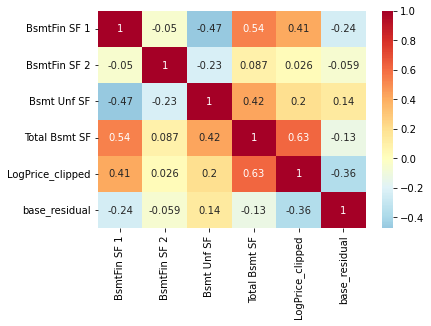

In [419]:
sns.heatmap(basement.corr(), center = 0, cmap = 'RdYlBu_r', annot = True)

In [420]:
sf_cols = [col for col in basement if basement[col].dtype == float]
sf_cols.remove('LogPrice_clipped')
sf_cols

['BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 'base_residual']

As a second check the total basement SF alone explans 39% of the variance in price compared to just barely more 40% with all SF features.

In [421]:
from sklearn.linear_model import LinearRegression
X = basement[sf_cols].fillna(0)

basement_sf_lr = LinearRegression()
basement_sf_lr.fit(X, basement['LogPrice_clipped'])
pd.DataFrame(basement_sf_lr.coef_, index = X.columns)
basement_sf_lr.score(X, basement['LogPrice_clipped'])

0.4757491718817576

In [422]:
X = basement[['Total Bsmt SF']].fillna(0)

basement_tot_sf_lr = LinearRegression()
basement_tot_sf_lr.fit(X, basement['LogPrice_clipped'])
# pd.DataFrame(basement_sf_lr.coef_, index = X.columns)
basement_tot_sf_lr.score(X, basement['LogPrice_clipped'])

0.39198467087035094

In [423]:
basement.head()

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,LogPrice_clipped,base_residual
0,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,11.779129,0.280580
1,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,12.301383,0.044222
2,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,11.599103,0.139583
3,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,12.066811,-0.007865
4,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,11.838626,-0.115473


##### Basement cleaning function

In [424]:
def basement_clean(df):
    df.fillna({'Bsmt Qual': 'NA', 'Bsmt Cond': 'NA', 'Bsmt Exposure': 'NA',
                'Total Bsmt SF': 0}, 
                inplace = True)
    df['Bsmt Qual'] = ord_read('Bsmt Qual', 'qual_na', df)
    df['Bsmt Cond'] = ord_read('Bsmt Cond', 'qual_na', df)
    df['Bsmt Exposure'] = ord_read('Bsmt Exposure', ['NA', 'No', 'Mn', 'Av', 'Gd'], df)
    df['Bsmt GLQ'] = ((df['BsmtFin Type 1'] == 'GLQ') | (df['BsmtFin Type 2'] == 'GLQ'))
    df.drop(columns = ['Bsmt Cond', 'BsmtFin Type 1', 'BsmtFin Type 2',
                       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF'], inplace = True)

#### Fireplaces

In [425]:
fire = df[['Fireplaces', 'Fireplace Qu', 'LogPrice_clipped', 'base_residual']].copy()

In [426]:
fire.head()

,Fireplaces,Fireplace Qu,LogPrice_clipped,base_residual
0,0,NaN,11.779129,0.280580
1,1,TA,12.301383,0.044222
2,0,NaN,11.599103,0.139583
3,0,NaN,12.066811,-0.007865
4,0,NaN,11.838626,-0.115473


Fire places can be capped at 2. Additonally, the relationship with price is non-linear so I'll add an extra indicator column 'is Fireplace'.

In [427]:
fire['Fireplaces'].value_counts()

0    1000
1     898
2     146
3       6
4       1
Name: Fireplaces, dtype: int64

In [428]:
fire.groupby('Fireplaces').mean()

,LogPrice_clipped,base_residual
Fireplaces,,
0,11.811912,0.022990
1,12.213636,-0.011385
2,12.315553,-0.077797
3,12.318392,0.301090
4,12.468437,0.131608


In [429]:
fire['Fireplace Qu'].fillna('NA', inplace = True)

In [430]:
fire['Fireplace Qu'].value_counts()

NA    1000
Gd     523
TA     407
Fa      59
Po      31
Ex      31
Name: Fireplace Qu, dtype: int64

In [431]:
fire.groupby('Fireplace Qu').mean()

,Fireplaces,LogPrice_clipped,base_residual
Fireplace Qu,,,
Ex,1.064516,12.657159,-0.022683
Fa,1.186441,12.024368,-0.047142
Gd,1.149140,12.281464,-0.021945
NA,0.000000,11.811912,0.022990
Po,1.000000,11.823423,-0.002781
TA,1.171990,12.188582,-0.011292


Fire quality appears to have an increasing linear or quadratic relationship w/ price.

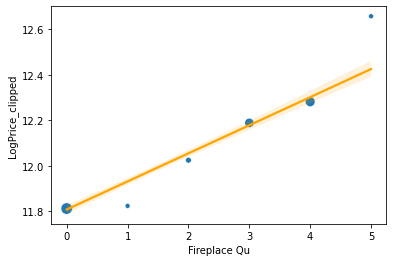

In [432]:
ord_plot('Fireplace Qu', 'qual_na',df = fire)

In [433]:
def fire_clean(df):
    df['Fireplaces'].clip(upper = 2, inplace = True)
    df['is Fireplace'] = (df['Fireplaces'] > 0)
    df['Fireplace Qu'].fillna('NA', inplace = True)
    

#### Bath rooms

In [434]:
bathrooms = df.loc[:, 'Bsmt Full Bath': 'Half Bath']
# bathrooms['LogPrice_clipped'] = df['LogPrice_clipped']

In [435]:
bathrooms.head()

,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath
0,0.0,0.0,2,1
1,1.0,0.0,2,1
2,1.0,0.0,1,0
3,0.0,0.0,2,1
4,0.0,0.0,2,0


2 null values - these have no basement anyway, so we can fill them with 0

In [436]:
basement[df['Bsmt Half Bath'].isna()]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,LogPrice_clipped,base_residual
616,NA,NA,NA,NaN,0.0,NaN,0.0,0.0,0.0,12.559191,-0.056535
1327,NA,NA,NA,NaN,NaN,NaN,NaN,NaN,NaN,11.277203,0.223866


In [437]:
bathrooms.fillna(0, inplace=True)

In [438]:
bathrooms.corr()

,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath
Bsmt Full Bath,1.000000,-0.146641,-0.011380,-0.026137
Bsmt Half Bath,-0.146641,1.000000,-0.060171,-0.047346
Full Bath,-0.011380,-0.060171,1.000000,0.153656
Half Bath,-0.026137,-0.047346,0.153656,1.000000


##### Sum all baths

In [439]:
bathrooms['Total Baths'] = bathrooms.sum(axis = 1)

In [440]:
bathrooms['Sum Baths'] = \
    (bathrooms['Bsmt Full Bath'] + bathrooms['Full Bath']) \
    + 1/2*(bathrooms['Bsmt Half Bath'] + bathrooms['Half Bath'])

In [441]:
bathrooms['LogPrice_clipped'] = df['LogPrice_clipped']
bathrooms['base_residual'] = df['base_residual']

In [442]:
bathrooms.head()

,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Total Baths,Sum Baths,LogPrice_clipped,base_residual
0,0.0,0.0,2,1,3.0,2.5,11.779129,0.280580
1,1.0,0.0,2,1,4.0,3.5,12.301383,0.044222
2,1.0,0.0,1,0,2.0,2.0,11.599103,0.139583
3,0.0,0.0,2,1,3.0,2.5,12.066811,-0.007865
4,0.0,0.0,2,0,2.0,2.0,11.838626,-0.115473


##### Correlation Testing

Based on the heat map the number of bathrooms has a strong correlation with price but not our base residuals.
Only the basement full bathrooms has a significant correlation remaining, but we already looked at other basement features that would capture this.

<AxesSubplot:>

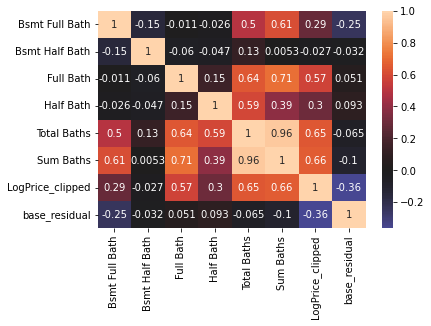

In [443]:
sns.heatmap(bathrooms.corr(), center = 0, annot = True)

<AxesSubplot:xlabel='Sum Baths', ylabel='LogPrice_clipped'>

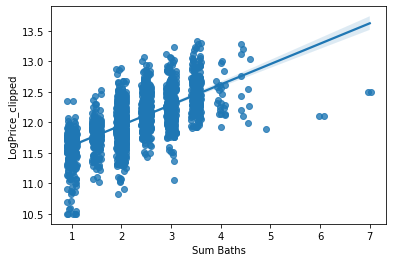

In [444]:
sns.regplot(x = 'Sum Baths', y = 'LogPrice_clipped', data = bathrooms, x_jitter=0.1)

<AxesSubplot:xlabel='Total Baths', ylabel='LogPrice_clipped'>

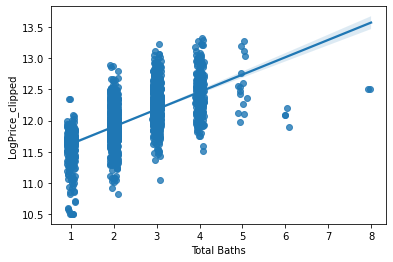

In [445]:
sns.regplot(x = 'Total Baths', y = 'LogPrice_clipped', data = bathrooms, x_jitter=0.1)

In [446]:
bathrooms.groupby('Sum Baths')[['LogPrice_clipped']].agg([np.mean, len])

LogPrice_clipped     
                      mean  len
Sum Baths                      
1.0              11.581006  315
1.5              11.806075  193
2.0              11.929565  636
2.5              12.170320  391
3.0              12.297845  278
3.5              12.498514  200
4.0              12.422703   22
4.5              12.629629   11
5.0              11.890677    1
6.0              12.095141    2
7.0              12.504324    2

In [447]:
bathrooms.groupby('Total Baths')[['LogPrice_clipped']].agg([np.mean, len])

LogPrice_clipped     
                        mean  len
Total Baths                      
1.0                11.581006  315
2.0                11.899188  815
3.0                12.226141  658
4.0                12.443810  242
5.0                12.590156   15
6.0                12.071758    4
8.0                12.504324    2

##### Outliers

In [448]:
many_bathrooms_idx = bathrooms.query('`Sum Baths` >= 5').index

In [449]:
from IPython.display import display
def all_cols(df):
    with pd.option_context('display.max_columns', None):
        return display(df)

all_cols(df_clean.loc[many_bathrooms_idx])

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Exposure,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,base_residual,LogPrice_clipped,isPool,Bsmt GLQ,is Fireplace,Sum Bath
791,763,904301060,90,RL,60.0,10800,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,5,5,1987,1988,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,4,4,1200.0,GasA,TA,Y,SBrkr,1200,0,0,1200,3,1,TA,5,Typ,0,NA,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,120,0,0,0,0,NaN,NaN,0,3,2009,WD,179000,-0.317941,12.095141,False,True,False,6.0
1325,1487,908102040,90,RL,67.0,8777,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,Duplex,1.5Fin,5,7,1900,2003,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,3,1,1272.0,GasA,Gd,Y,SBrkr,1272,928,0,2200,4,2,TA,9,Typ,0,NA,NaN,NaN,NaN,0.0,0.0,NaN,NaN,N,0,70,0,0,0,GdPrv,NaN,0,9,2008,WD,145900,-0.071454,11.890677,False,False,False,5.0
1566,816,906230010,90,RL,NaN,11855,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,Duplex,2Story,7,5,2000,2000,Hip,CompShg,VinylSd,VinylSd,BrkFace,23.0,TA,TA,PConc,5,1,1168.0,GasA,Ex,Y,SBrkr,1168,1619,0,2787,6,2,TA,8,Typ,2,TA,BuiltIn,2000.0,Fin,4.0,820.0,TA,TA,Y,312,0,0,0,0,NaN,NaN,0,10,2009,WD,269500,0.059596,12.504324,False,True,True,7.0
1584,764,904301070,90,RL,60.0,10800,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,5,5,1987,1988,Gable,CompShg,Plywood,Plywood,None,0.0,TA,Gd,CBlock,4,4,1200.0,GasA,TA,Y,SBrkr,1200,0,0,1200,3,1,TA,5,Typ,0,NA,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,120,0,0,0,0,NaN,NaN,0,3,2009,WD,179000,-0.317941,12.095141,False,True,False,6.0
1605,817,906230020,90,RL,NaN,7939,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Feedr,Norm,Duplex,2Story,7,5,2000,2000,Hip,CompShg,VinylSd,VinylSd,BrkFace,23.0,TA,TA,PConc,5,1,1168.0,GasA,Ex,Y,SBrkr,1168,1619,0,2787,6,2,TA,8,Typ,2,TA,BuiltIn,2000.0,Fin,4.0,820.0,TA,TA,Y,312,0,0,0,0,NaN,NaN,0,10,2009,WD,269500,0.059596,12.504324,False,True,True,7.0


Let's clip the bathrooms variable to limit outliers.

In [450]:
bathrooms['Sum clipped'] = bathrooms['Sum Baths'].clip(upper = 4.5)
bathrooms['Total clipped'] = bathrooms['Total Baths'].clip(upper = 5)

<AxesSubplot:>

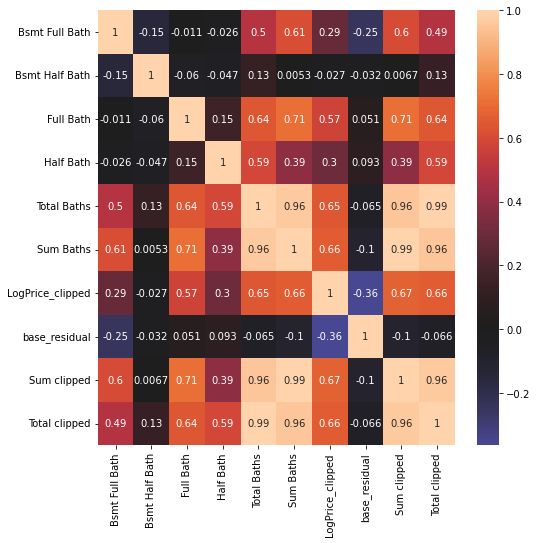

In [451]:
plt.figure(figsize = (8,8))
sns.heatmap(bathrooms.corr(), center = 0, annot = True)

##### Bathroom cleaning function

In [452]:
def bathroom_clean(df):
    df[['Bsmt Full Bath', 'Bsmt Half Bath']].fillna(0)
    df['Sum Bath'] = (df['Bsmt Full Bath'] + df['Full Bath']) + 1/2*(df['Bsmt Half Bath'] + df['Half Bath'])
    df.drop(columns = ['Bsmt Half Bath', 'Bsmt Full Bath', 'Full Bath', 'Half Bath'], inplace = True)

#### Garages

In [453]:
garage = df.loc[:, 'Garage Type': 'Garage Cond']

In [454]:
garage.head()

,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
0,Attchd,1976.0,RFn,2.0,475.0,TA,TA
1,Attchd,1997.0,RFn,2.0,559.0,TA,TA
2,Detchd,1953.0,Unf,1.0,246.0,TA,TA
3,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA
4,Detchd,1957.0,Unf,2.0,484.0,TA,TA


In [455]:
garage['Garage Type'].value_counts()

Attchd     1213
Detchd      536
BuiltIn     132
Basment      27
2Types       19
CarPort      11
Name: Garage Type, dtype: int64

In [456]:
garage['Garage Cars'].value_counts()

2.0    1136
1.0     524
3.0     263
0.0     113
4.0      13
5.0       1
Name: Garage Cars, dtype: int64

<AxesSubplot:xlabel='Garage Area', ylabel='Count'>

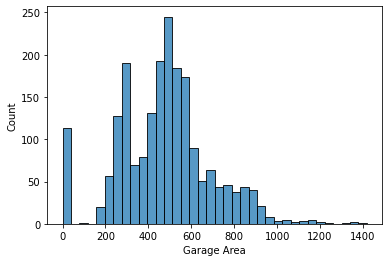

In [457]:
sns.histplot(x = 'Garage Area', data = garage)

#### Fence

In [ ]:
df['Fence'].value_counts()

MnPrv    227
GdPrv     83
GdWo      80
MnWw      10
Name: Fence, dtype: int64

In [ ]:
df['Fence'].fillna('NA', inplace = True)

Fence is tecnically ordinal (NA < MnWw < GdWo < MnPrv < GdPrv) but the relationship to both price and residuals are non linear. Therefore it would be better to OHE fence.

In [491]:
df.groupby('Fence')[['LogPrice_clipped', 'base_residual']].mean().reindex(index = ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'])

,LogPrice_clipped,base_residual
Fence,,
NA,12.059895,0.005180
MnWw,11.802545,-0.006761
GdWo,11.807132,0.018316
MnPrv,11.859423,-0.020492
GdPrv,12.031732,-0.023507


In [ ]:
def fence_clean(df):
    df['Fence'].fillna('NA', inplace = True)
    # df['Fence'] = ord_read('Fence', ['NA', 'MnWw', 'GdWo', 'MnPr'])

### All data cleaning.

In [488]:
def clean_data(df):
    df_clean = df.copy()

    # call all helpers
    neighborhood_clean(df_clean)
    pool_clean(df_clean)
    alley_clean(df_clean)
    masonry_clean(df_clean)
    basement_clean(df_clean)
    fire_clean(df_clean)
    bathroom_clean(df_clean)
    # TODO garage_clean
    fence_clean(df_clean)

    return df_clean

In [459]:
df_clean = clean_data(df)
df_test_clean = clean_data(df_test)

In [460]:
df_clean.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Exposure', 'Total Bsmt SF', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Gr Liv Area', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces',
       'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish',
       'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond',
       'Paved Drive', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
       '3Ssn Porch', 'Sc

In [461]:
df_clean.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Mo Sold,Yr Sold,Sale Type,SalePrice,base_residual,LogPrice_clipped,isPool,Bsmt GLQ,is Fireplace,Sum Bath
0,109,533352170,60,RL,NaN,13517,Pave,None,IR1,Lvl,...,3,2010,WD,130500,0.280580,11.779129,False,True,False,2.5
1,544,531379050,60,RL,43.0,11492,Pave,None,IR1,Lvl,...,4,2009,WD,220000,0.044222,12.301383,False,True,True,3.5
2,153,535304180,20,RL,68.0,7922,Pave,None,Reg,Lvl,...,1,2010,WD,109000,0.139583,11.599103,False,True,False,2.0
3,318,916386060,60,RL,73.0,9802,Pave,None,Reg,Lvl,...,4,2010,WD,174000,-0.007865,12.066811,False,False,False,2.5
4,255,906425045,50,RL,82.0,14235,Pave,None,IR1,Lvl,...,3,2010,WD,138500,-0.115473,11.838626,False,False,False,2.0


In [462]:
pd.DataFrame(df_clean.isna().sum(), columns = ['na_count']).query('na_count > 0')

,na_count
Lot Frontage,330
Garage Type,113
Garage Yr Blt,114
Garage Finish,114
Garage Cars,1
Garage Area,1
Garage Qual,114
Garage Cond,114
Fence,1651
Misc Feature,1986


### Impute missing values

* df['Lot Frontage'] mean imputation with missing indicator

In [470]:
from sklearn.impute import SimpleImputer
si = SimpleImputer()
df_clean['Lot Frontage'] = si.fit_transform(df_clean[['Lot Frontage']])
df_test_clean['Lot Frontage'] = si.transform(df_test_clean[['Lot Frontage']])

### Feature engineering

Some feature engineering is done during the cleaning section. This is especially for functions that need to be done after imputing missing values and when imputation can't be done to a default value (0 or 'NA').

In [475]:
def feature_engineering(df):
    df_features = df.copy()

    # Feature engineering functions
    lot_features(df_features)

    return df_features

In [476]:
df_final = feature_engineering(df_clean)
df_test_final = feature_engineering(df_test_clean)

In [477]:
all_cols(df_final)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Exposure,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,base_residual,LogPrice_clipped,isPool,Bsmt GLQ,is Fireplace,Sum Bath,Lot Ratio
0,109,533352170,60,RL,69.0552,13517,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,3,1,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,3,1,Gd,6,Typ,0,NA,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,NaN,NaN,0,3,2010,WD,130500,0.280580,11.779129,False,True,False,2.5,2.834572
1,544,531379050,60,RL,43.0000,11492,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,4,1,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,NaN,NaN,0,4,2009,WD,220000,0.044222,12.301383,False,True,True,3.5,6.215251
2,153,535304180,20,RL,68.0000,7922,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,3,1,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,3,1,Gd,5,Typ,0,NA,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,NaN,NaN,0,1,2010,WD,109000,0.139583,11.599103,False,True,False,2.0,1.713235
3,318,916386060,60,RL,73.0000,9802,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,4,1,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,3,1,TA,7,Typ,0,NA,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,NaN,NaN,0,4,2010,WD,174000,-0.007865,12.066811,False,False,False,2.5,1.839369
4,255,906425045,50,RL,82.0000,14235,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,2,1,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,3,1,TA,6,Typ,0,NA,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,NaN,NaN,0,3,2010,WD,138500,-0.115473,11.838626,False,False,False,2.0,2.117043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,1587,921126030,20,RL,79.0000,11449,Pave,None,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,4,3,1884.0,GasA,Ex,Y,SBrkr,1728,0,0,1728,3,1,Gd,7,Typ,1,Gd,Attchd,2007.0,Fin,2.0,520.0,TA,TA,Y,0,276,0,0,0,NaN,NaN,0,1,2008,WD,298751,-0.105534,12.607366,False,True,True,3.0,1.834482
2047,785,905377130,30,RL,69.0552,12342,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,4,5,1940,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,3,1,861.0,GasA,Ex,Y,SBrkr,861,0,0,861,1,1,TA,4,Typ,0,NA,Detchd,1961.0,Unf,2.0,539.0,TA,TA,Y,158,0,0,0,0,NaN,NaN,0,3,2009,WD,82500,0.089703,11.320554,False,False,False,1.0,2.588170
2048,916,909253010,50,RL,57.0000,7558,Pave,None,Reg,Bnk,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,1.5Fin,6,6,1928,1950,Gable,CompShg,BrkFace,Stone,None,0.0,TA,TA,BrkTil,3,1,896.0,GasA,Gd,Y,SBrkr,1172,741,0,1913,3,1,TA,9,Typ,1,TA,Detchd,1929.0,Unf,2.0,342.0,Fa,Fa,Y,0,0,0,0,0,NaN,NaN,0,3,2009,WD,177000,0.081380,12.083905,False,False,True,1.5,2.326254
2049,639,5351

Features to add

In [ ]:
# Last remodel = Year sold - year remodeled
# is remodeled = (Year remodeled - year built) > 0
# Is shed

In [479]:
df['Misc Feature'].value_counts()

Shed    56
Gar2     4
Othr     3
TenC     1
Elev     1
Name: Misc Feature, dtype: int64

In [486]:
np.abs(df['base_residual']).agg([np.mean, np.std])

mean    0.116726
std     0.116912
Name: base_residual, dtype: float64